<a href="https://colab.research.google.com/github/ambreenraheem/Deep-Learning/blob/main/DL_age_gender_and_race_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ambreen Abdul Raheem
Deep Learning age_gender_and_race_detection


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 76% 251M/331M [00:00<00:00, 734MB/s] 
100% 331M/331M [00:00<00:00, 591MB/s]


In [4]:
import zipfile

In [5]:
# Unzip the file
zip_file = '/content/utkface-new.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/utkface')

In [6]:
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [7]:
print(len(filenames))
print(filenames[:3])

23708
['46_1_3_20170120140919993.jpg.chip.jpg', '1_1_2_20161219155627605.jpg.chip.jpg', '39_0_0_20170104204804020.jpg.chip.jpg']


# Data preprocessing

In [15]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

In [ ]:
# image_path

# From Unstructured data to Structured data

In [9]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [10]:
#remove outliers
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [11]:
df.head()

,image,age,gender,race
0,45_0_4_20170117172212027.jpg.chip.jpg,45,0,4
1,72_0_0_20170111210555874.jpg.chip.jpg,72,0,0
2,51_1_4_20170103234622539.jpg.chip.jpg,51,1,4
3,12_0_4_20170103200626630.jpg.chip.jpg,12,0,4
4,15_1_2_20161219190855506.jpg.chip.jpg,15,1,2


In [12]:
gender_dict = {0:"Male",1:"Female"}

In [13]:
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [14]:
df.head()

,image,age,gender,race
0,45_0_4_20170117172212027.jpg.chip.jpg,45,0,4
1,72_0_0_20170111210555874.jpg.chip.jpg,72,0,0
2,51_1_4_20170103234622539.jpg.chip.jpg,51,1,4
3,12_0_4_20170103200626630.jpg.chip.jpg,12,0,4
4,15_1_2_20161219190855506.jpg.chip.jpg,15,1,2


In [16]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [17]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [18]:
df.head()

,image,age,gender,race
0,45_0_4_20170117172212027.jpg.chip.jpg,45,0,4
1,72_0_0_20170111210555874.jpg.chip.jpg,72,0,0
2,51_1_4_20170103234622539.jpg.chip.jpg,51,1,4
3,12_0_4_20170103200626630.jpg.chip.jpg,12,0,4
4,15_1_2_20161219190855506.jpg.chip.jpg,15,1,2


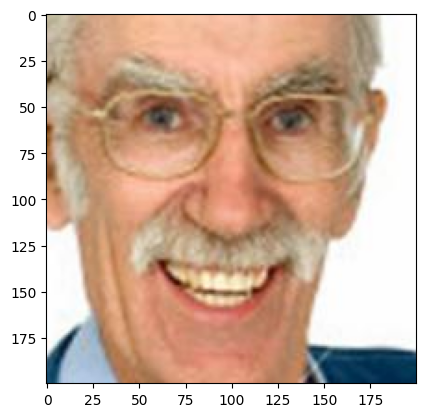

In [19]:
img = Image.open("/content/utkface/UTKFace/"+df['image'][1])
plt.imshow(img)

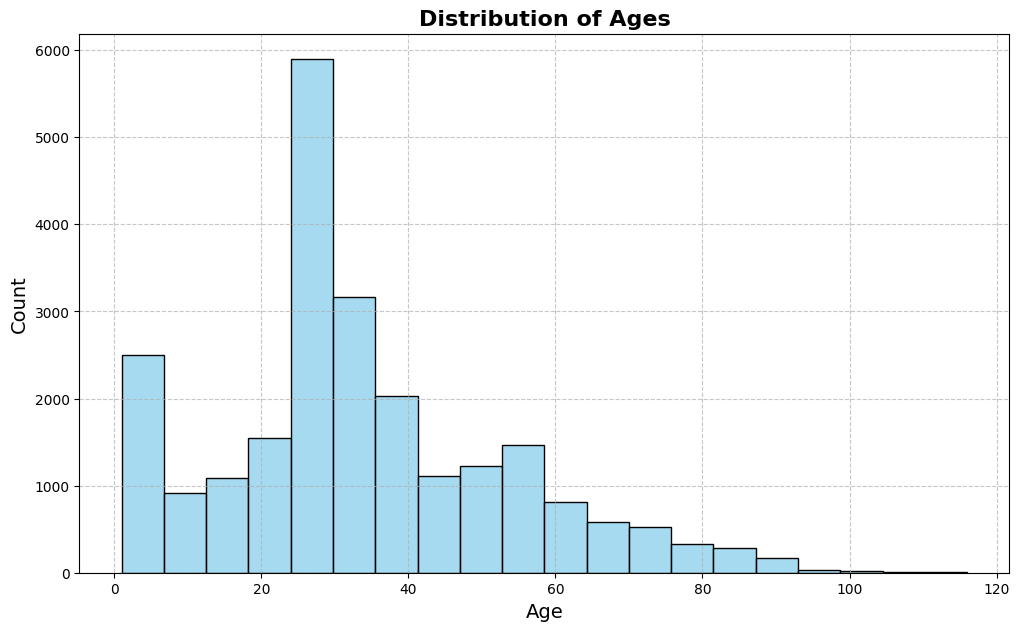

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))


sns.histplot(df['age'], bins=20, kde=False, color='skyblue', edgecolor='black')


plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()


<ipython-input-21-36725a16e635>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

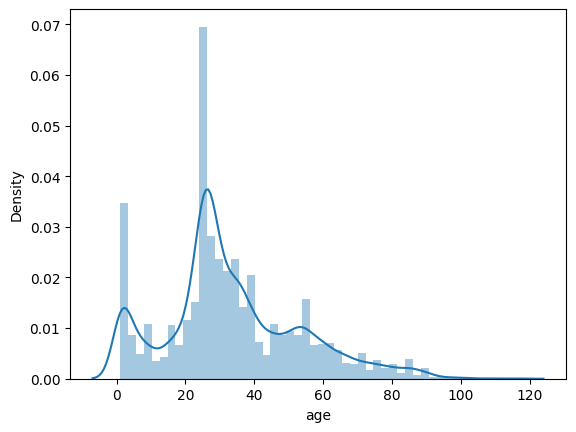

In [21]:
sns.distplot(df.age)

# Plotting Images

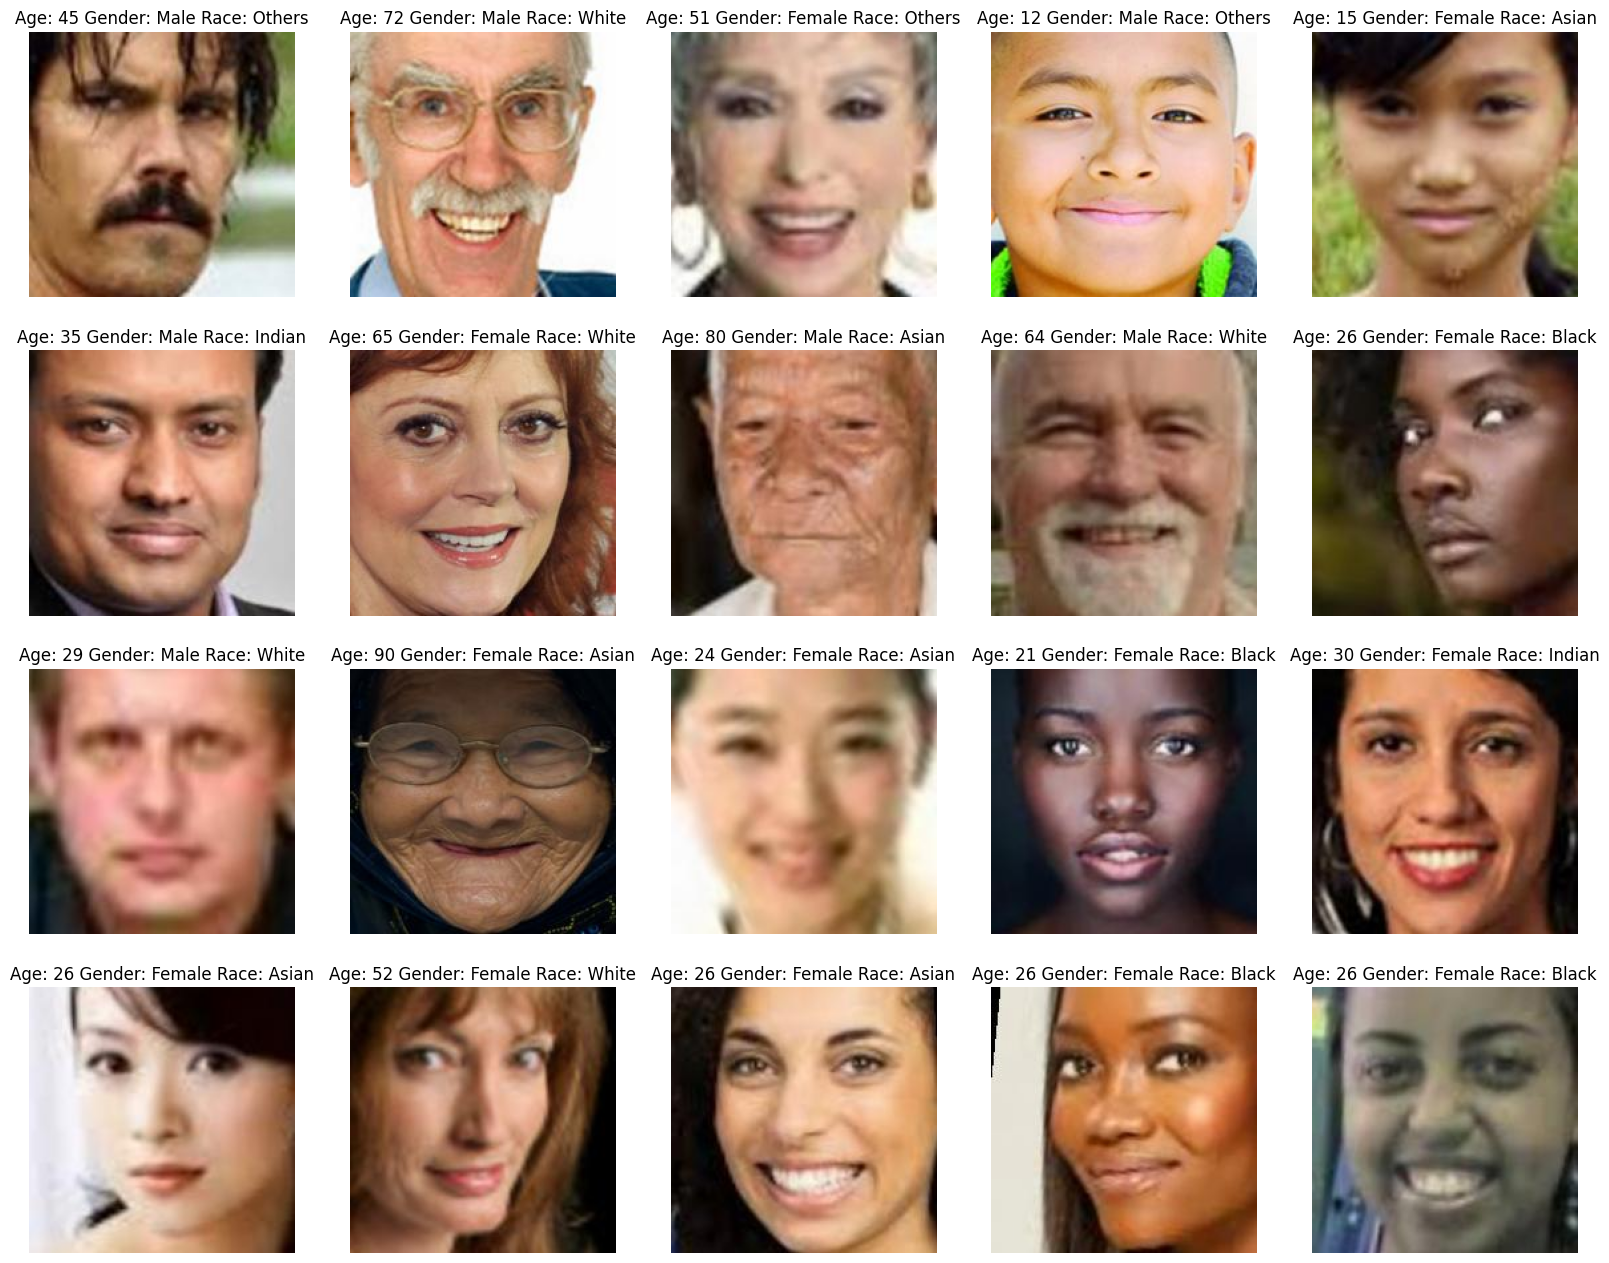

In [22]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset.
I have already shuffled all the data to ensure no biasness in the dataset.

In [23]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [24]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [25]:
train.shape

(18964, 4)

In [26]:
test.shape

(4741, 4)

In [27]:
train.head()

,image,age,gender,race
21098,12_0_4_20170103201607807.jpg.chip.jpg,12,0,4
20881,26_0_1_20170113134249474.jpg.chip.jpg,26,0,1
21548,25_1_0_20170109214731480.jpg.chip.jpg,25,1,0
13630,4_1_0_20170109190824547.jpg.chip.jpg,4,1,0
8225,40_1_0_20170116224841122.jpg.chip.jpg,40,1,0


# Extracting Features

In [ ]:
# print(f"Shape of the first image: {x_train[0].shape}")

In [28]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/utkface/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [29]:
x_train.shape

(18964, 224, 224, 3)

# Normalizing data

In [ ]:
# x_train = x_train/255

In [30]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

This line of code uses the to_categorical function from the tensorflow.keras.utils module to perform one-hot encoding on the y_race variable.

In [31]:
from tensorflow.keras.utils import to_categorical

y_race = to_categorical(y_race, num_classes=5)

In [32]:
y_race

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

# Creating model

In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform


This line of code imports the glorot_uniform initializer from the tensorflow.keras.initializers module.

Initializers are used to set the initial weights of the layers in a neural network. The glorot_uniform initializer (also known as Xavier uniform initializer) draws samples from a uniform distribution within a specific range.

In [37]:
# Load the VGG16 model
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 layers
for layer in conv_base.layers:
    layer.trainable = False

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Apply the VGG16 base model
X = conv_base(inputs)

# Flatten the output
X = Flatten()(X)

# Dense layers for shared representation
dense_1 = Dense(256, activation='relu')(X)
dropout_1 = Dropout(0.4)(dense_1)

# Dense layers specific to each task
dense_2 = Dense(256, activation='relu')(X)
dropout_2 = Dropout(0.4)(dense_2)

dense_3 = Dense(128, activation='relu')(X)
dropout_3 = Dropout(0.4)(dense_3)

# Output layers
output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

In [38]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │  3,211,392 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
# Compile the model
model.compile(
    optimizer='adam',
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [40]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  6,422,784 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │  3,211,392 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Training the model

In [41]:
y_race

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [42]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the model with the best 'race_output' performance
checkpoint = ModelCheckpoint(
    'best_model_by_race_output.keras',  # Path where the best model will be saved
    monitor='val_race_output_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for the metric: 'min' for loss
    verbose=1  # Verbosity level
)

In [43]:
# Train the model with the checkpoint callback
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=20,  # Set the number of epochs as needed
    batch_size=32,  # Set the batch size as needed
    validation_split=0.1,  # Use a validation split or provide validation data
    callbacks=[checkpoint]  # Add the checkpoint callback
)

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - age_output_loss: 2956.8091 - age_output_mean_absolute_error: 37.5310 - gender_output_accuracy: 0.8011 - gender_output_loss: 2.4908 - loss: 2963.8730 - race_output_accuracy: 0.4150 - race_output_loss: 4.5718
Epoch 1: val_race_output_loss improved from inf to 1.33892, saving model to best_model_by_race_output.keras
534/534 ━━━━━━━━━━━━━━━━━━━━ 132s 211ms/step - age_output_loss: 2954.5354 - age_output_mean_absolute_error: 37.5241 - gender_output_accuracy: 0.8012 - gender_output_loss: 2.4876 - loss: 2961.5933 - race_output_accuracy: 0.4150 - race_output_loss: 4.5672 - val_age_output_loss: 1460.7024 - val_age_output_mean_absolute_error: 32.8842 - val_gender_output_accuracy: 0.8877 - val_gender_output_loss: 0.2626 - val_loss: 1467.4347 - val_race_output_accuracy: 0.4191 - val_race_output_loss: 1.3389
Epoch 2/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - age_output_loss: 1473.5791 - age_output_mean_absolute_error: 32.8648 - gender_outp

# Predicting test image

In [44]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [45]:
import numpy

In [ ]:
print(np.argmax(y_race[index]))

1


Original: Gender =  Female  Age =  53  Race =  Black
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediction: Gender =  Female  Age =  30  Race =  Black


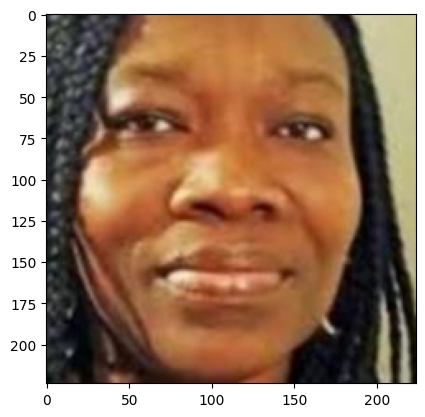

In [46]:
index=100
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index]," Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender," Age = ", pred_age," Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediction: Gender = Female, Age = 41, Race = White


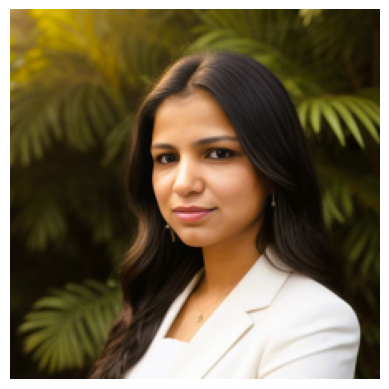

In [69]:
my_img_path = "/content/ME_AI.jpg"  # Changed variable name to indicate it's a path

# Load and preprocess the uploaded image
# Use PIL to open the image file
my_img = Image.open(my_img_path).convert('RGB')
my_img = my_img.resize((224, 224))

# Convert the image to a NumPy array
my_img_array = np.array(my_img)

# The reshape is no longer needed here as np.array(my_img) already creates the correct shape if my_img is a PIL image object
# my_img_array = my_img_array.reshape(224, 224, 3) # This line is redundant and can be removed

# Make a prediction - The model expects a batch of images, so reshape to (1, 224, 224, 3)
pred = model.predict(my_img_array.reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

# Display the results
print(f"Prediction: Gender = {pred_gender}, Age = {pred_age}, Race = {pred_race}")
plt.imshow(my_img_array) # Use the numpy array for displaying with matplotlib
plt.axis('off')
plt.show()

In [70]:
test.head()

,image,age,gender,race
17816,38_1_1_20170113012502193.jpg.chip.jpg,38,1,1
15082,26_1_1_20170112210451957.jpg.chip.jpg,26,1,1
22832,28_1_2_20170116222623761.jpg.chip.jpg,28,1,2
16076,29_0_1_20170113145429766.jpg.chip.jpg,29,0,1
8972,41_0_0_20170105173537165.jpg.chip.jpg,41,0,0


In [71]:
#converting Image to numpy array (extracting feature)
x_test = []
for file in test.image:
    img = load_img("/content/utkface/UTKFace/" + file)

    # Resize the image using the correct resampling method
    img = img.resize((224, 224), Image.LANCZOS)

    # Convert the image to a NumPy array
    img = np.array(img)
    x_test.append(img)

# Convert the list of images to a NumPy array
x_test = np.array(x_test)

In [72]:
#converting labels
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [73]:
test_acc = model.evaluate(x_test, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)

In [74]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])

total loss: 293.0008850097656
gender loss: 0.5720187425613403
age loss: 290.8671875
race loss: 1.2229033708572388


In [75]:
x_test.shape

(4741, 224, 224, 3)

In [76]:
pred = model.predict(x_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step


In [77]:
pred[2][0]

array([0.18373226, 0.29218218, 0.18947509, 0.2471135 , 0.08749691],
      dtype=float32)

In [78]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [79]:
#pred to df
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [80]:
df_pred['gender'].value_counts()

,count
gender,
Male,2567
Female,2174


In [81]:
df_pred['age'].value_counts()

,count
age,
9,623
19,216
18,203
21,202
25,195
22,192
20,190
23,184
17,182


In [84]:
df_pred['race'].value_counts()

,count
race,
Black,2472
White,2268
Asian,1
